In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import regionmask
import pandas as pd

In [2]:
increase_amt = 2 #per grid box #kg/m2/s (change to 2 if doing a 2x check simulation)

In [3]:
#ECA, TIB, EAS

In [4]:
path = '../GCrundirs/IRF_runs/mod_inputs/BC-em-anthro_CMIP_CEDS_2016'

In [5]:
ds = xr.open_dataset(path + '.nc', engine = "netcdf4")

In [6]:
sectors_pulsed = ['BC_agr',
 'BC_ene',
 'BC_ind',
 'BC_rco',
 'BC_slv',
 'BC_tra',
 'BC_wst']
#pulsing all but shipping since that is offshore and we're doing land based emissions right now. when you do ocean locations you can pulse only shipping

### Pulse options
We have multiple options for the type of pulse, but have determined that it doesn't make a very large difference in the outcome, so are using a weighted pulse. This weights the pulse by the existing emissions fields. We use a 2x pulse for checks and a 15x pulse to create the functions.

# CEDS Weighted Pulse

In [7]:
### create a pulsed dataset
pulse_ds =  ds.drop('BC_shp').copy()
pulse_ds *= increase_amt

In [8]:
### import the regions we are interested in ###
ar6_coal_location = pd.read_csv('ar6_coal_location.csv', index_col = 'number').to_dict()['acronym']

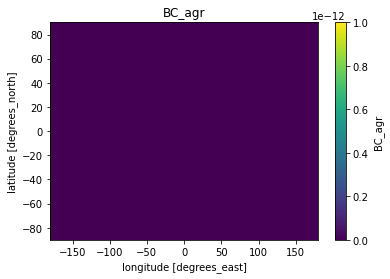

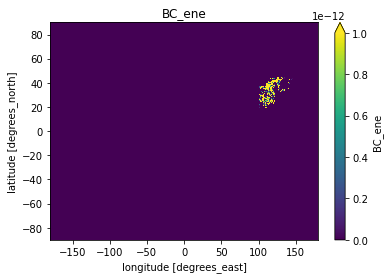

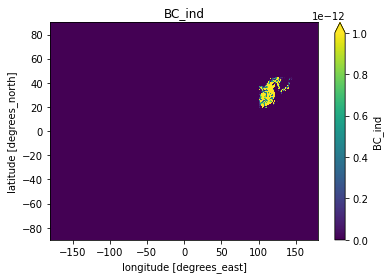

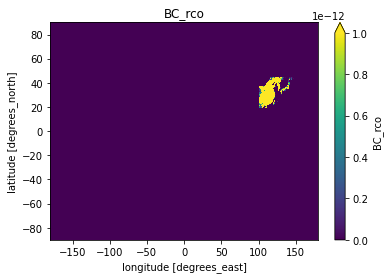

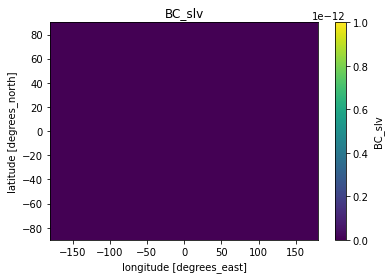

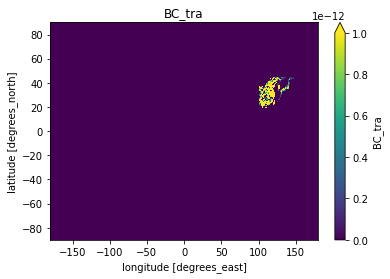

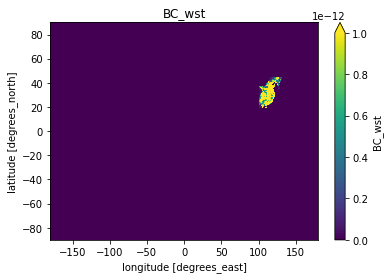

In [10]:
### Global: Modify CEDs files
regions = regionmask.defined_regions.ar6.land
for r in [35]: 
    ds_new = ds.copy()
    mask = regions.mask(pulse_ds, lon_name = 'lon', lat_name = 'lat')
    contiguous_mask = ~np.isnan(mask)& (mask == r)
    ds_pulse_reg = pulse_ds.where(contiguous_mask) #create a mask on our pulsed dataset
    for sector in sectors_pulsed:
        ds_new[sector] = ds_pulse_reg[sector].fillna(0) + ds_new[sector] #modifying the BC_ene output, but it doesn't matter which one is chosen as all grids get the same pulse
        ds_new[sector].attrs = ds[sector].attrs
        fig, ax = plt.subplots()
        ((ds_new[sector]).isel(time = 0)-(ds[sector]).isel(time = 0)).plot(ax = ax, vmin = 0, vmax = 1e-12)
        plt.title(sector)
    ds_new.to_netcdf(path + '_' + ar6_coal_location[r] + f'_{increase_amt}x.nc')

# CEDS Weighted by existing patterns

# CEDS Cosine Weighted

In [5]:
#estimated center of the US at 47 N 101 W

In [6]:
center = ds.sel(lon = -98, lat = 39, method = 'nearest')

In [7]:
lat_w = 20 #degrees (doing 2x our grid size, can change)
lon_w = 25 #degrees (doing 2x our grid size, can change)

In [8]:
A = increase_amt

In [9]:
pulse_ds = A*np.cos(np.pi/2 * (ds['lat'] - center['lat'])/lat_w)**2 * np.cos(np.pi/2 * (ds['lon'] - center['lon'])/lon_w)**2

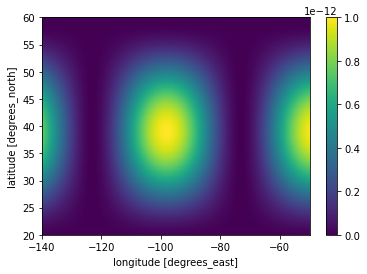

In [29]:
pulse_ds.plot()

In [10]:
us_pulse = pulse_ds.loc[dict(lat = slice(center['lat']-lat_w, center['lat']+lat_w))].loc[dict(lon = slice(center['lon']-lon_w, center['lon']+lon_w))].rename('pulse')

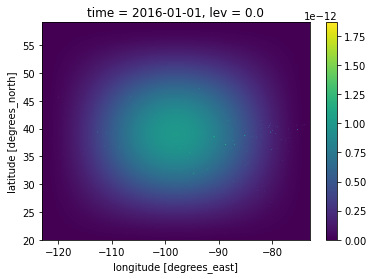

In [11]:
(ds['PEC']+pulse_ds.loc[dict(lat = slice(center['lat']-lat_w,center['lat']+lat_w))].loc[dict(lon = slice(center['lon']-lon_w,center['lon']+lon_w))]).isel(time = 0, lev = 0).plot()

In [12]:
ds_out = xr.merge([ds['PEC'], us_pulse])

In [13]:
ds_out['pulse'] = ds_out['pulse'].fillna(0)

In [14]:
ds_out['pulse_added'] = (ds_out['PEC'] + ds_out['pulse'])

In [15]:
ds_out['pulse_added'].attrs = ds['PEC'].attrs

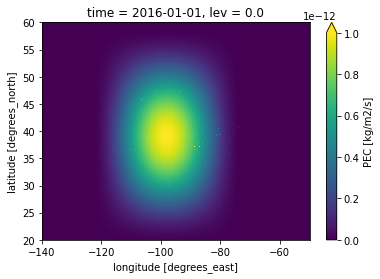

In [16]:
(ds_out['pulse_added']).isel(lev = 0).plot(vmax = 1e-12)

In [25]:
ds['PEC'] = ds_out['pulse_added'].astype('float32')

In [27]:
ds['PEC'].dtype

dtype('float32')

In [28]:
ds.to_netcdf(path + '_us_cos_pulse.nc')

# US Only, NEI Modification

01 done


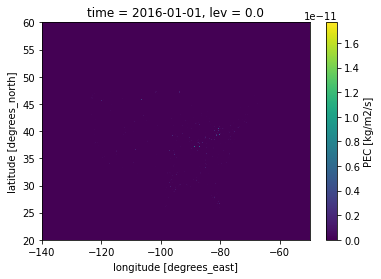

In [30]:
### US Only (modify NEI Files)
# POC for OC (in NEI)
# PEC for BC (in NEI)
poll = 'PEC'
increase_amt = 15
for m in ['01']:#,'04','07','10']:

    ds = xr.open_dataset(f'../GCrundirs/IRF_runs/mod_inputs/2016fh_16j_emln_ptegu_0pt1degree_3D_month_{m}.ncf', engine = "netcdf4")
    ds[poll] *= increase_amt
    ds[poll].isel(time = 0, lev = 0).plot()
    #ds.to_netcdf(f'../GCrundirs/IRF_runs/mod_inputs/2016fh_16j_emln_ptegu_0pt1degree_3D_month_{m}_mod_{poll}_varied.ncf')
    print(m, 'done')

In [35]:
ds = xr.open_dataset(f'../GCrundirs/IRF_runs/mod_inputs/2016fh_16j_emln_ptegu_0pt1degree_3D_month_{m}.ncf', engine = "netcdf4")